# Explore here

In [5]:
# Your code here

# my installation commands
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sqlalchemy import create_engine, text
import streamlit as st
from dotenv import load_dotenv
import os
import joblib
import shap

In [6]:
#I ran into some issues organizing the folders, so with this, I'm asking Python to always start from the project root.

import os
os.chdir("/workspaces/Volnuratus-Non-Victus")

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load datasets
df_ddos = pd.read_csv("data/raw/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False)
df_port = pd.read_csv("data/raw/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory=False)

# Clean column names
df_ddos.columns = df_ddos.columns.str.strip()
df_port.columns = df_port.columns.str.strip()

# Combine them
df = pd.concat([df_ddos, df_port], ignore_index=True)

# Check labels
print(df["Label"].value_counts())

# Encode labels
df_cleaned = df.copy()
le = LabelEncoder()
df_cleaned["Label_encoded"] = le.fit_transform(df_cleaned["Label"])


Label
BENIGN      225255
PortScan    158930
DDoS        128027
Name: count, dtype: int64


In [8]:
import sqlite3

# Take a sample of 10,000 rows
df_sample = df.head(10000)

# Save to a smaller SQLite DB
conn = sqlite3.connect("data/processed/cicids_sample.db")
df_sample.to_sql("network_traffic", conn, if_exists="replace", index=False)
conn.close()


In [9]:

# Inspecting each dataframe safely

if 'ddos_df' in locals():
    print("DDoS:", ddos_df.shape)
    print(ddos_df.columns.tolist())
    print(ddos_df.head())

if 'portscan_df' in locals():
    print("PortScan:", portscan_df.shape)
    print(portscan_df.columns.tolist())
    print(portscan_df.head())

if 'wednesday_df' in locals():
    print("Wednesday:", wednesday_df.shape)
    print(wednesday_df.columns.tolist())
    print(wednesday_df.head())
else:
    print("Wednesday dataframe not loaded.")



Wednesday dataframe not loaded.


In [10]:
# I'm removing leading/trailing spaces safely

if 'ddos_df' in locals():
    ddos_df.columns = ddos_df.columns.str.strip()

if 'portscan_df' in locals():
    portscan_df.columns = portscan_df.columns.str.strip()

if 'wednesday_df' in locals():
    wednesday_df.columns = wednesday_df.columns.str.strip()
else:
    print("Wednesday dataframe not loaded, skipping column strip.")



Wednesday dataframe not loaded, skipping column strip.


In [11]:
# Adding source labels to track origin during merges

if 'ddos_df' in locals():
    ddos_df["Source"] = "DDoS"

if 'portscan_df' in locals():
    portscan_df["Source"] = "PortScan"

if 'wednesday_df' in locals():
    wednesday_df["Source"] = "Wednesday"
else:
    print("Wednesday dataframe not loaded, skipping source label.")


Wednesday dataframe not loaded, skipping source label.


In [12]:
# Merging safely

dfs_to_merge = []

if 'ddos_df' in locals():
    dfs_to_merge.append(ddos_df)

if 'portscan_df' in locals():
    dfs_to_merge.append(portscan_df)

if 'wednesday_df' in locals():
    dfs_to_merge.append(wednesday_df)
else:
    print("Wednesday dataframe not loaded, skipping merge.")

if dfs_to_merge:
    combined_df = pd.concat(dfs_to_merge, ignore_index=True)
    print("Combined shape:", combined_df.shape)
else:
    print("No dataframes available to merge.")



Wednesday dataframe not loaded, skipping merge.
No dataframes available to merge.


In [13]:
#I'm inspecting my labels, counting how many "Benign" rows vs attact types. (DDoS, PortScan, etc.)

df["Label"].value_counts()



Label
BENIGN      225255
PortScan    158930
DDoS        128027
Name: count, dtype: int64

In [14]:
#previewing column types

df_cleaned.dtypes.value_counts()

int64      55
float64    24
object      1
Name: count, dtype: int64

In [15]:
#picking a categorical feature
df.select_dtypes(include="object").columns.tolist()


['Label']

In [16]:
#Listin the first 30 column names to pick from

df.columns[:30].tolist()


['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min']

In [17]:
# Subsetting the data after selecting 20 predictors
selected_columns = [
    'Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
    'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
    'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std',
    'Fwd IAT Mean', 'Bwd IAT Mean', 'Fwd IAT Max', 'Label'
]

df_subset = df[selected_columns].copy()
print("Subset shape:", df_subset.shape)
df_subset.head()


Subset shape: (512212, 20)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Fwd IAT Mean,Bwd IAT Mean,Fwd IAT Max,Label
0,54865,3,2,0,12,0,6,6.0,0.0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,0.0,3,BENIGN
1,55054,109,1,1,6,6,6,6.0,0.0,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,0.0,0.0,0,BENIGN
2,55055,52,1,1,6,6,6,6.0,0.0,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,0.0,0.0,0,BENIGN
3,46236,34,1,1,6,6,6,6.0,0.0,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,0.0,0.0,0,BENIGN
4,54863,3,2,0,12,0,6,6.0,0.0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,0.0,3,BENIGN


In [18]:
#Handling missing values - this will show us the top 10 columns with the most missing values

df_subset.isnull().sum().sort_values(ascending=False).head(10)


Flow Bytes/s                   19
Destination Port                0
Total Fwd Packets               0
Flow Duration                   0
Total Backward Packets          0
Total Length of Fwd Packets     0
Fwd Packet Length Max           0
Total Length of Bwd Packets     0
Fwd Packet Length Std           0
Bwd Packet Length Max           0
dtype: int64

In [19]:
#I chose to fill it with the median since it is a numeric column with low missingness

In [20]:
#I'm now filling the missing values in the "Flow bytes" column

df["Flow Bytes/s"].fillna(df["Flow Bytes/s"].median(), inplace=True)

#Trying my distribution to be stable and avoid skewing

/tmp/ipykernel_1361/1215113440.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Flow Bytes/s"].fillna(df["Flow Bytes/s"].median(), inplace=True)


In [21]:
#One-hot encoding to convert my categorical column ('source') into binary flags

df = pd.get_dummies(df, columns=["Label"], drop_first=True)

#this will also drop 'Source_DDoS' to avoid multicollinearity

In [22]:
print("Final shape:", df.shape)
print(df.dtypes.value_counts())


Final shape: (512212, 80)
int64      54
float64    24
bool        2
Name: count, dtype: int64


In [23]:
#I'm encoding my target variable so it's ready for modeling and database storage

df_cleaned["Label"] = df_cleaned["Label"].astype("category")
df_cleaned["Label_encoded"] = df_cleaned["Label"].cat.codes



In [24]:
#a small optional dictionary that helps to interpret predictions later

label_mapping = dict(enumerate(df_cleaned["Label"].cat.categories))
print(label_mapping)



{0: 'BENIGN', 1: 'DDoS', 2: 'PortScan'}


In [25]:
# --- Save DataFrame into SQLite and create sample DB ---
import sqlite3
import pandas as pd

# Connect to the big DB
conn = sqlite3.connect("data/processed/cicids_cleaned.db")

# Save DataFrame to SQLite in manageable chunks
df.to_sql("network_traffic", conn, index=False, if_exists="replace", chunksize=10000)

# Load a sample of the table
df_sample = pd.read_sql("SELECT * FROM network_traffic LIMIT 10000;", conn)

# Save sample to a smaller DB
conn_sample = sqlite3.connect("data/processed/cicids_sample.db")
df_sample.to_sql("network_traffic", conn_sample, if_exists="replace", index=False)

# Close connections
conn.close()
conn_sample.close()


# --- Query counts per class using one-hot encoded columns ---
# Re-open connection to the big DB
conn = sqlite3.connect("data/processed/cicids_cleaned.db")

query = """
SELECT
    SUM(Label_DDoS) AS DDoS_count,
    SUM(Label_PortScan) AS PortScan_count,
    COUNT(*) - SUM(Label_DDoS) - SUM(Label_PortScan) AS BENIGN_count
FROM network_traffic;
"""

class_counts = pd.read_sql(query, conn)
print(class_counts)

conn.close()


   DDoS_count  PortScan_count  BENIGN_count
0      128027          158930        225255


In [26]:
import sqlite3
import pandas as pd

# Re-open connection to the big DB
conn = sqlite3.connect("data/processed/cicids_cleaned.db")

# Average flow duration per label - this shows us which types of attacks tend to last longer
avg_flow_duration_query = """
SELECT
    AVG("Flow Duration") FILTER (WHERE Label_DDoS = 1) AS avg_ddos_duration,
    AVG("Flow Duration") FILTER (WHERE Label_PortScan = 1) AS avg_portscan_duration,
    AVG("Flow Duration") FILTER (WHERE Label_DDoS = 0 AND Label_PortScan = 0) AS avg_benign_duration
FROM network_traffic;
"""

avg_durations = pd.read_sql(avg_flow_duration_query, conn)
print(avg_durations)

conn.close()



   avg_ddos_duration  avg_portscan_duration  avg_benign_duration
0       1.695559e+07           82820.228371         1.342272e+07


In [27]:
import sqlite3
import pandas as pd

# Re-open connection to the big DB
conn = sqlite3.connect("data/processed/cicids_cleaned.db")

flow_bytes_summary_query = """
SELECT
    'DDoS' AS Label,
    AVG("Flow Bytes/s") AS avg_bytes,
    MIN("Flow Bytes/s") AS min_bytes,
    MAX("Flow Bytes/s") AS max_bytes,
    COUNT(*) AS count
FROM network_traffic
WHERE Label_DDoS = 1

UNION ALL

SELECT
    'PortScan' AS Label,
    AVG("Flow Bytes/s") AS avg_bytes,
    MIN("Flow Bytes/s") AS min_bytes,
    MAX("Flow Bytes/s") AS max_bytes,
    COUNT(*) AS count
FROM network_traffic
WHERE Label_PortScan = 1

UNION ALL

SELECT
    'BENIGN' AS Label,
    AVG("Flow Bytes/s") AS avg_bytes,
    MIN("Flow Bytes/s") AS min_bytes,
    MAX("Flow Bytes/s") AS max_bytes,
    COUNT(*) AS count
FROM network_traffic
WHERE Label_DDoS = 0 AND Label_PortScan = 0
ORDER BY avg_bytes DESC;
"""

flow_bytes_summary = pd.read_sql(flow_bytes_summary_query, conn)
print(flow_bytes_summary)

conn.close()



      Label  avg_bytes     min_bytes  max_bytes   count
0      DDoS        inf  2.212181e-01        inf  128027
1  PortScan        inf  0.000000e+00        inf  158930
2    BENIGN        inf -1.930000e+08        inf  225255


In [28]:
import sqlite3
import pandas as pd

# Re-open connection to the big DB
conn = sqlite3.connect("data/processed/cicids_cleaned.db")

# Top 5 most common destination ports - reveals which ports are often used or targeted
top_ports_query = """
SELECT "Destination Port", COUNT(*) AS count
FROM network_traffic
GROUP BY "Destination Port"
ORDER BY count DESC
LIMIT 5;
"""

top_ports = pd.read_sql(top_ports_query, conn)
print(top_ports)

conn.close()


   Destination Port   count
0                80  153692
1                53   90694
2               443   40420
3              8080    1288
4                22    1257


<Axes: title={'center': 'Label Distribution'}>

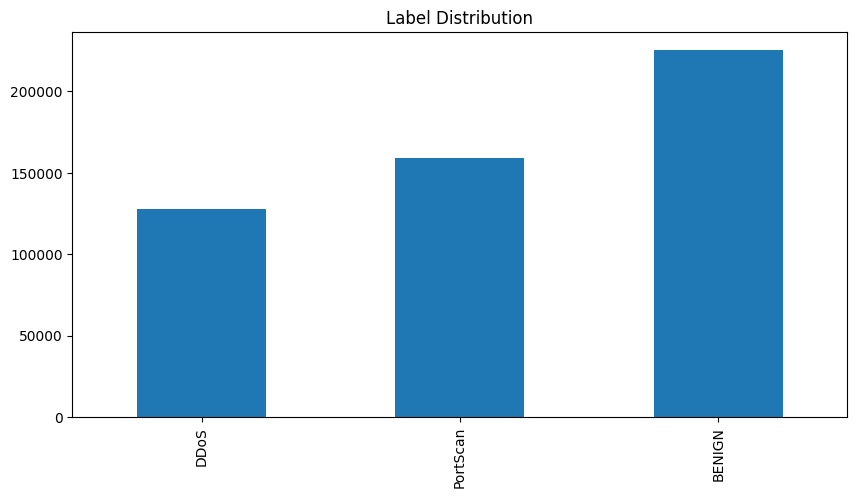

In [29]:
#EDA
# Rebuild label counts from one-hot encoded columns
label_counts = {
    "DDoS": df["Label_DDoS"].sum(),
    "PortScan": df["Label_PortScan"].sum(),
    "BENIGN": len(df) - df["Label_DDoS"].sum() - df["Label_PortScan"].sum()
}

# Plot distribution
pd.Series(label_counts).plot(kind="bar", figsize=(10,5), title="Label Distribution")



In [30]:
#Before moving deeper in my EDA - I'm checking how many rows contain missing values

df.isnull().sum().sum()

#Since the amount of missing values is low out of over 1.2 million rows, I think it's better to drop them.

np.int64(0)

In [31]:
# Replace inf/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaNs
df_cleaned = df.dropna()


In [32]:
#Log transforms

df_cleaned["Flow Bytes/s_log"] = np.log1p(df_cleaned["Flow Bytes/s"])
df_cleaned["Flow Duration_log"] = np.log1p(df_cleaned["Flow Duration"])
df_cleaned["Flow Packets/s_log"] = np.log1p(df_cleaned["Flow Packets/s"])


/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1361/3612996117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Flow Bytes/s_log"] = np.log1p(df_cleaned["Flow Bytes/s"])
/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1361/3612996117.py:4: SettingWithCopyW

<Axes: >

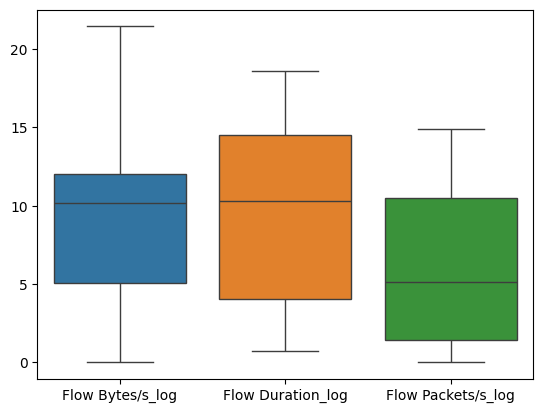

In [33]:
#Box plot

sns.boxplot(data=df_cleaned[["Flow Bytes/s_log", "Flow Duration_log", "Flow Packets/s_log"]])


In [34]:
#ensuring that log-transformed features does not contain any invalid value before modeling

df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    "Flow Bytes/s_log", "Flow Duration_log", "Flow Packets/s_log"
])


array([[<Axes: title={'center': 'Flow Bytes/s_log'}>,
        <Axes: title={'center': 'Flow Duration_log'}>],
       [<Axes: title={'center': 'Flow Packets/s_log'}>, <Axes: >]],
      dtype=object)

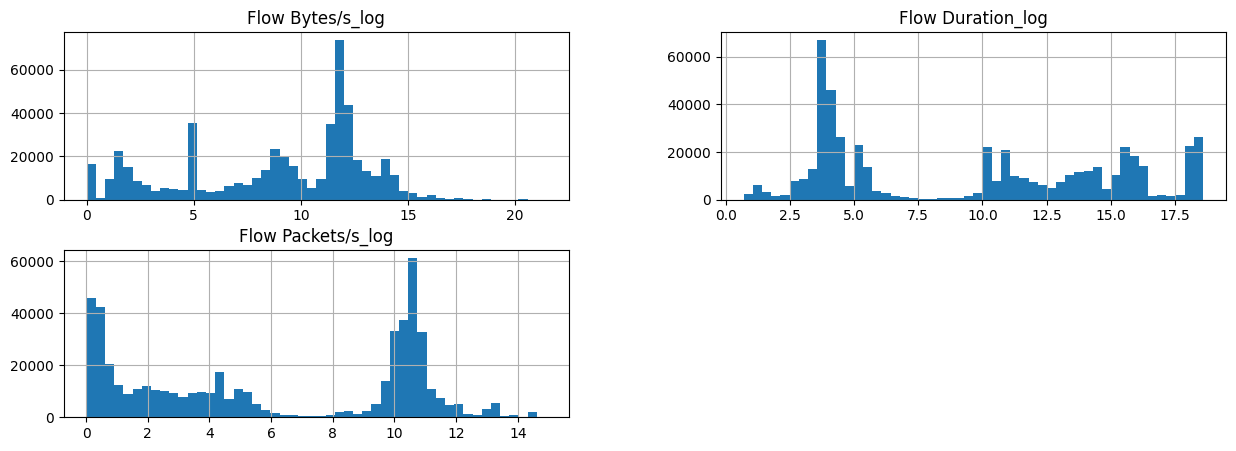

In [35]:
#Histogram

df_cleaned[["Flow Bytes/s_log", "Flow Duration_log", "Flow Packets/s_log"]].hist(figsize=(15, 5), bins=50)


In [36]:
#dropping redundant versions

df_cleaned.drop(columns=["Flow Bytes/s", "Flow Duration", "Flow Packets/s"], inplace=True)


In [37]:
from sklearn.preprocessing import LabelEncoder

# Rebuild Label + Label_encoded from one-hot flags
df_cleaned["Label"] = df_cleaned.apply(
    lambda row: "DDoS" if row["Label_DDoS"] == 1
                else "PortScan" if row["Label_PortScan"] == 1
                else "BENIGN",
    axis=1
)

le = LabelEncoder()
df_cleaned["Label_encoded"] = le.fit_transform(df_cleaned["Label"])


In [38]:
# Drop constant columns (std == 0) before correlation
numeric_df = df_cleaned.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(columns=["Label_DDoS","Label_PortScan","Label_encoded"], errors="ignore")
numeric_df = numeric_df.loc[:, numeric_df.std() > 0]

corrs = {col: df_cleaned["Label_encoded"].corr(df_cleaned[col]) for col in numeric_df.columns}
label_corr_series = pd.Series(corrs).dropna().sort_values(ascending=False)

print(label_corr_series.head(15))


PSH Flag Count            0.648574
Flow Packets/s_log        0.472614
min_seg_size_forward      0.382194
Flow Bytes/s_log          0.339080
Init_Win_bytes_forward    0.319772
Bwd Packets/s             0.201600
Bwd Packet Length Std     0.024329
Bwd Packet Length Max     0.006701
Bwd Packet Length Mean   -0.006020
Avg Bwd Segment Size     -0.006020
Packet Length Variance   -0.008701
ECE Flag Count           -0.009850
RST Flag Count           -0.009850
Flow IAT Min             -0.031754
Down/Up Ratio            -0.032319
dtype: float64


In [39]:
import pandas as pd

# Step 1: Keep only numeric features
numeric_df = df_cleaned.select_dtypes(include=[np.number])

# Step 2: Drop redundant label columns
numeric_df = numeric_df.drop(columns=["Label_DDoS", "Label_PortScan", "Label_encoded"], errors="ignore")

# Step 3: Compute correlation feature-by-feature
corrs = {}
for col in numeric_df.columns:
    corrs[col] = df_cleaned["Label_encoded"].corr(df_cleaned[col])

# Step 4: Convert to Series and sort
label_corr_series = pd.Series(corrs).sort_values(ascending=False)

print("Correlation with Label_encoded:\n")
print(label_corr_series.head(15))  # top 15 features


Correlation with Label_encoded:

PSH Flag Count            0.648574
Flow Packets/s_log        0.472614
min_seg_size_forward      0.382194
Flow Bytes/s_log          0.339080
Init_Win_bytes_forward    0.319772
Bwd Packets/s             0.201600
Bwd Packet Length Std     0.024329
Bwd Packet Length Max     0.006701
Bwd Packet Length Mean   -0.006020
Avg Bwd Segment Size     -0.006020
Packet Length Variance   -0.008701
ECE Flag Count           -0.009850
RST Flag Count           -0.009850
Flow IAT Min             -0.031754
Down/Up Ratio            -0.032319
dtype: float64


/home/vscode/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/vscode/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


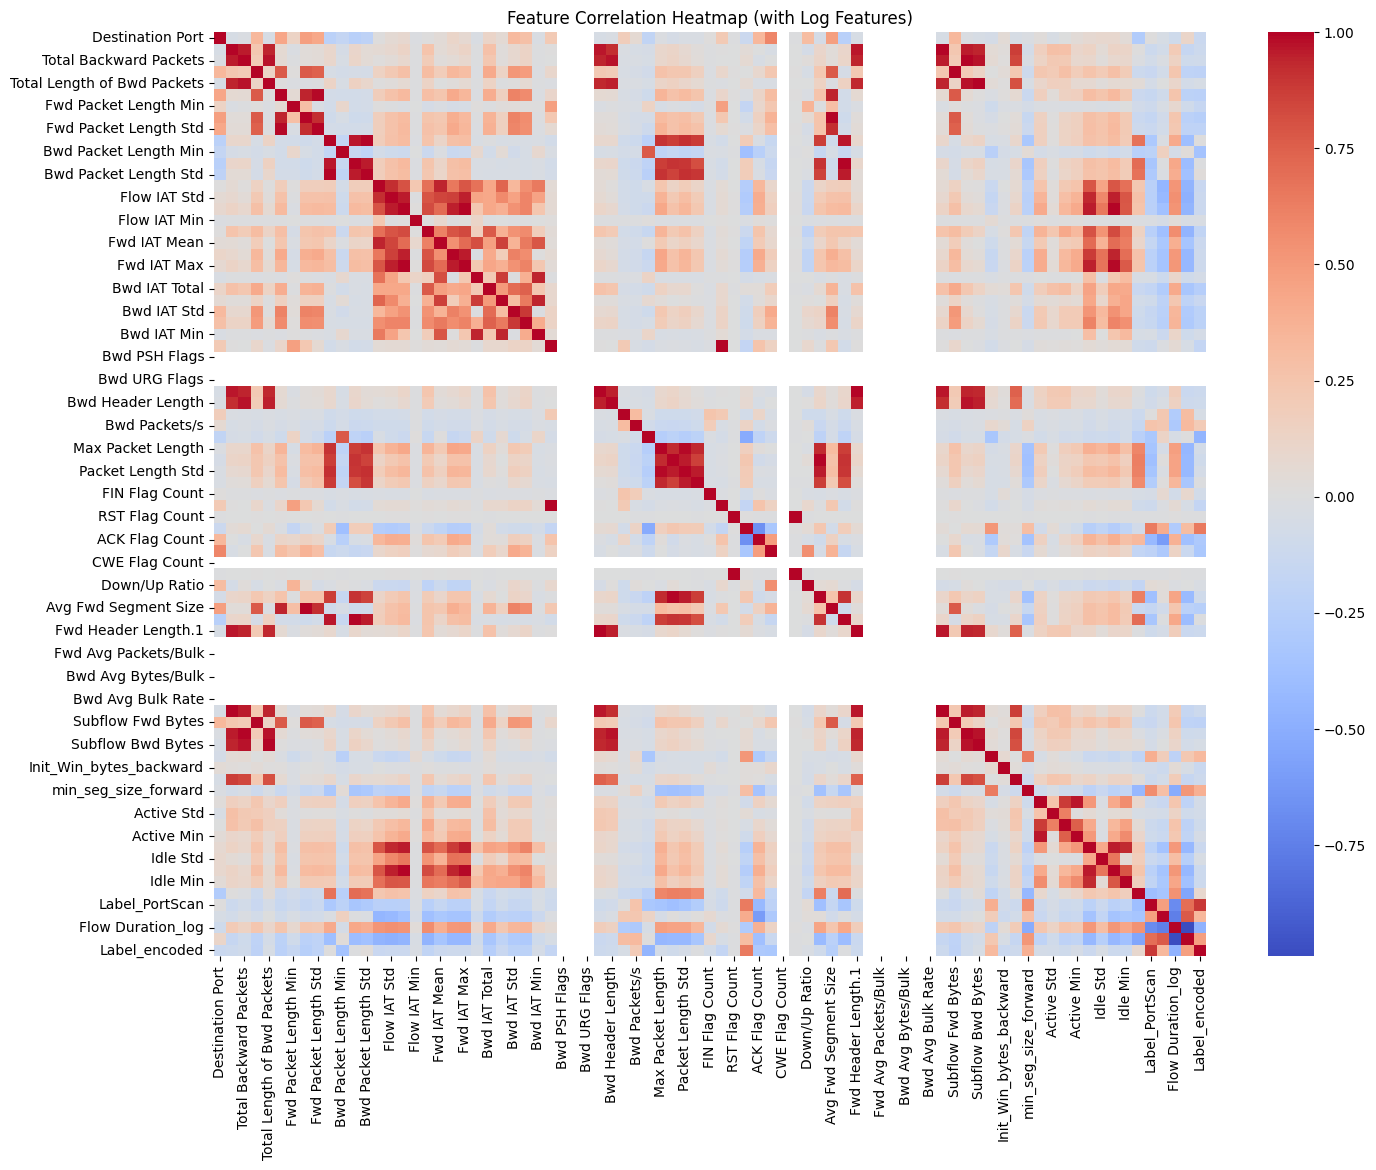

In [40]:
#heatmap

plt.figure(figsize=(16,12))
sns.heatmap(df_cleaned.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (with Log Features)")
plt.show()


In [41]:
from sklearn.preprocessing import LabelEncoder

# Rebuild df_cleaned with a proper Label column from one-hot encoding
df_cleaned = df.copy()

# Create a human-readable Label column
df_cleaned["Label"] = df_cleaned.apply(
    lambda row: "DDoS" if row["Label_DDoS"] == 1 
                else "PortScan" if row["Label_PortScan"] == 1 
                else "BENIGN",
    axis=1
)

# Encode labels
le = LabelEncoder()
df_cleaned["Label_encoded"] = le.fit_transform(df_cleaned["Label"])

# Quick check
print(df_cleaned["Label"].value_counts())
print(df_cleaned["Label_encoded"].value_counts())



Label
BENIGN      225255
PortScan    158930
DDoS        128027
Name: count, dtype: int64
Label_encoded
0    225255
2    158930
1    128027
Name: count, dtype: int64


In [42]:
#I was struggling a little bit interpreting the heat-map and the correlation, so I extracted the correlation directly.

# Step 1: Get correlation matrix (all numeric columns)
corr_matrix = df_cleaned.select_dtypes(include=['number']).corr()

# Step 2: Extract correlations with Label_encoded
label_corr = corr_matrix["Label_encoded"].sort_values(ascending=False)

# Step 3: Display as a clean table
print("Correlation with Label_encoded:\n")
print(label_corr)


Correlation with Label_encoded:

Label_encoded             1.000000
PSH Flag Count            0.648900
min_seg_size_forward      0.382487
Init_Win_bytes_forward    0.319958
Bwd Packets/s             0.201563
                            ...   
Fwd Avg Packets/Bulk           NaN
Fwd Avg Bulk Rate              NaN
Bwd Avg Bytes/Bulk             NaN
Bwd Avg Packets/Bulk           NaN
Bwd Avg Bulk Rate              NaN
Name: Label_encoded, Length: 79, dtype: float64


In [43]:
import numpy as np
import pandas as pd

# --- Feature engineering: create log-transformed versions ---
# Use log1p (log(1+x)) to avoid issues with zeros
df_cleaned["Flow Duration_log"] = np.log1p(df_cleaned["Flow Duration"])
df_cleaned["Flow Bytes/s_log"] = np.log1p(df_cleaned["Flow Bytes/s"])
df_cleaned["Flow Packets/s_log"] = np.log1p(df_cleaned["Flow Packets/s"])

# Example of a categorical feature: create a binary flag for Wednesday traffic
# (adjust if you have a 'Timestamp' column to extract day-of-week)
df_cleaned["Source_Wednesday"] = df_cleaned.get("Source_Wednesday", 0)

# Example of a source-based feature: PortScan indicator
# If you already have Label_PortScan, you can use that instead
df_cleaned["Source_PortScan"] = df_cleaned["Label_PortScan"]

# --- Feature selection and model prep ---
features = ["Source_PortScan", "Flow Packets/s_log", "Flow Duration_log", "Source_Wednesday", "Flow Bytes/s_log"]
X = df_cleaned[features]
y = df_cleaned["Label_encoded"]

print("Feature matrix shape:", X.shape)
print("Target distribution:", y.value_counts())



Feature matrix shape: (512212, 5)
Target distribution: Label_encoded
0    225255
2    158930
1    128027
Name: count, dtype: int64


/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
from sklearn.model_selection import train_test_split

# Check class distribution
print("Class distribution in y:\n", y.value_counts())

if y.nunique() > 1:
    # Multiple classes → safe to stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Stratified split performed.")
else:
    # Only one class → stratify would fail
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("Non-stratified split performed (only one class present).")


Class distribution in y:
 Label_encoded
0    225255
2    158930
1    128027
Name: count, dtype: int64
Stratified split performed.


In [45]:
#Train/Split test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [46]:
import pandas as pd

# Save test features and labels to CSV for Streamlit
X_test.to_csv("data/X_test.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)

# (Optional) Save training sets too, if you want them later
X_train.to_csv("data/X_train.csv", index=False)
y_train.to_csv("data/y_train.csv", index=False)


In [47]:
# Create lightweight demo test set for Streamlit Cloud
X_demo = X_test.sample(n=200, random_state=42)
y_demo = y_test.loc[X_demo.index]

X_demo.to_csv("data/X_test_demo.csv", index=False)
y_demo.to_csv("data/y_test_demo.csv", index=False)


In [48]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)


In [49]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")  # safer than filling with 0
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [51]:
#Trying to scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [52]:
#Trying first with logistic regression

# Train on scaled data
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_scaled = logreg.predict(X_test_scaled)

print("Confusion Matrix (Scaled):\n", confusion_matrix(y_test, y_pred_scaled))
print("\nClassification Report (Scaled):\n", classification_report(y_test, y_pred_scaled))


Confusion Matrix (Scaled):
 [[36441  8610     0]
 [12789 12817     0]
 [    0     0 31786]]

Classification Report (Scaled):
               precision    recall  f1-score   support

           0       0.74      0.81      0.77     45051
           1       0.60      0.50      0.55     25606
           2       1.00      1.00      1.00     31786

    accuracy                           0.79    102443
   macro avg       0.78      0.77      0.77    102443
weighted avg       0.79      0.79      0.79    102443



In [53]:
# Parameter distributions
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

# Take a 20% sample of training data for tuning
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,
    random_state=42,
    stratify=y_train   # keeps class balance
)

# Randomized search on the smaller set
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=3,   # fewer combos
    cv=2,       # lighter cross-validation
    scoring='accuracy',
    n_jobs=1,
    random_state=42
)

random_search.fit(X_small, y_small)
print("Best Parameters:", random_search.best_params_)

# Retrain final model on full dataset with best params
rf_final = RandomForestClassifier(
    **random_search.best_params_,
    random_state=42,
    class_weight='balanced'
)

rf_final.fit(X_train, y_train)
y_pred_final = rf_final.predict(X_test)

import joblib

# Save the trained model into the repo
joblib.dump(rf_final, "models/rf_model.pkl")
print("Model saved to models/rf_model.pkl")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
Model saved to models/rf_model.pkl


[Before prediction] Memory used: 2208.64 MB
[After prediction] Memory used: 2208.64 MB
Confusion Matrix:
 [[43432  1619     0]
 [  324 25282     0]
 [    0     0 31786]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     45051
           1       0.94      0.99      0.96     25606
           2       1.00      1.00      1.00     31786

    accuracy                           0.98    102443
   macro avg       0.98      0.98      0.98    102443
weighted avg       0.98      0.98      0.98    102443

Accuracy: 0.9810333551340745
Precision: 0.9817005429758782
Recall: 0.9810333551340745
F1 Score: 0.9811289583508835
[Before recall chart] Memory used: 2208.64 MB


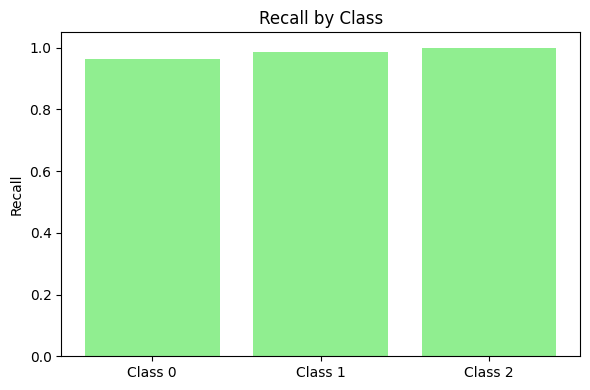

[After recall chart] Memory used: 2208.64 MB
[Before feature importance] Memory used: 2208.64 MB


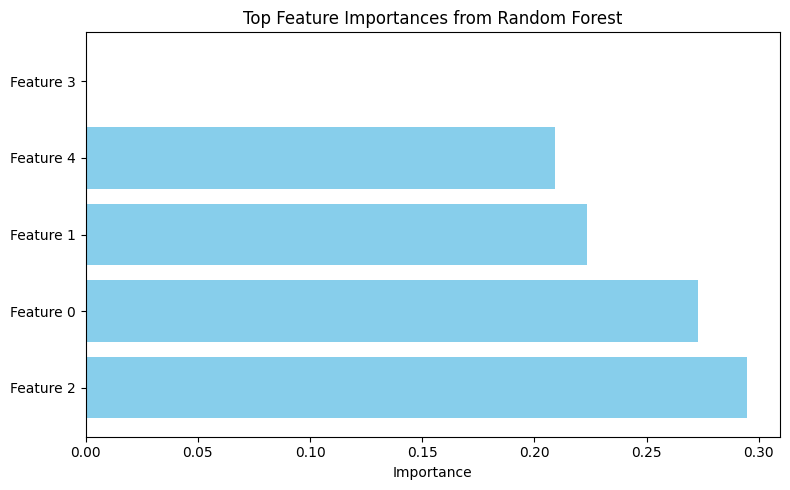

[After feature importance] Memory used: 2208.64 MB


In [54]:
import psutil, os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

# Helper function to print memory usagec- doing these to keep an eye on memory due to constant Kernel crashes
def check_memory(stage):
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024 ** 2
    print(f"[{stage}] Memory used: {mem:.2f} MB")

# Predictions
check_memory("Before prediction")
y_pred_final = rf_final.predict(X_test)
check_memory("After prediction")

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

# Overall metrics
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_final, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_final, average='weighted'))

# Recall comparison chart (multiclass-safe)
check_memory("Before recall chart")
recalls = recall_score(y_test, y_pred_final, average=None)
labels = [f"Class {cls}" for cls in sorted(set(y_test))]

plt.figure(figsize=(6,4))
plt.bar(labels, recalls, color='lightgreen')
plt.ylabel("Recall")
plt.title("Recall by Class")
plt.tight_layout()
plt.show()
check_memory("After recall chart")

# Feature Importance (with DataFrame-safe feature names)
check_memory("Before feature importance")
importances = rf_final.feature_importances_

# If X_train is a DataFrame, use its columns; otherwise create generic names
if hasattr(X_train, "columns"):
    feature_names = X_train.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Limit to top 20 if too many features
if len(feat_df) > 30:
    feat_df = feat_df.head(20)

plt.figure(figsize=(8,5))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top Feature Importances from Random Forest')
plt.tight_layout()
plt.show()
check_memory("After feature importance")


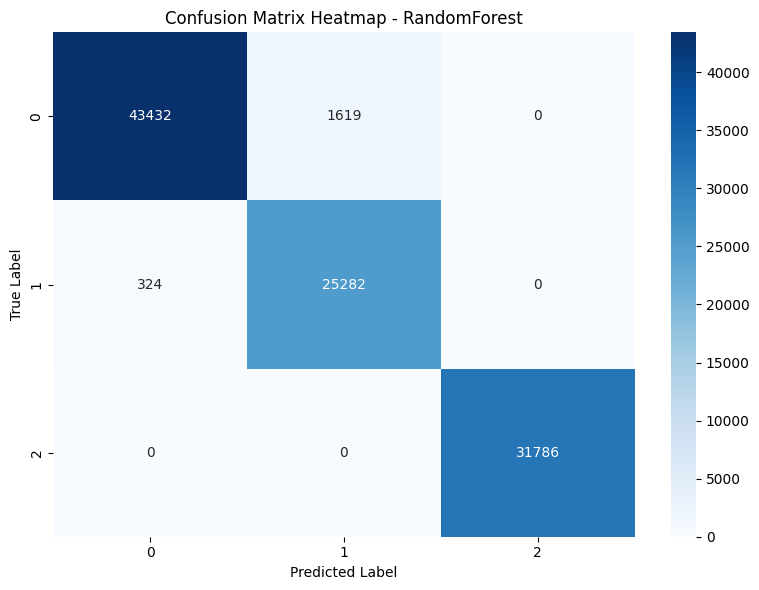

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

#heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=sorted(set(y_test)), 
            yticklabels=sorted(set(y_test)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap - RandomForest")
plt.tight_layout()
plt.show()


In [56]:
import os, joblib
from sklearn.metrics import accuracy_score, classification_report

# Ensuring that models folder exists
os.makedirs("models", exist_ok=True)

# Saving final RandomForest model
joblib.dump(rf_final, "models/rf_model.pkl")
print("✅ Model saved to models/rf_model.pkl")

# Reloading model
rf_loaded = joblib.load("models/rf_model.pkl")

# Verifying my predictions match
y_pred_loaded = rf_loaded.predict(X_test)
print("✅ Loaded model predictions identical to original:",
      (y_pred_loaded == y_pred_final).all())

# Printing the final accuracy
final_acc = accuracy_score(y_test, y_pred_loaded)
print(f"📊 Final Model Accuracy: {final_acc:.4f}")

# Quick classification report summary
print("\n📑 Final Classification Report:\n")
print(classification_report(y_test, y_pred_loaded))




✅ Model saved to models/rf_model.pkl
✅ Loaded model predictions identical to original: True
📊 Final Model Accuracy: 0.9810

📑 Final Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     45051
           1       0.94      0.99      0.96     25606
           2       1.00      1.00      1.00     31786

    accuracy                           0.98    102443
   macro avg       0.98      0.98      0.98    102443
weighted avg       0.98      0.98      0.98    102443

